In [2]:
import sys
sys.path.append('/Users/xenodennis/Documents/Fun/HaleyAI')

In [3]:
from typing import Literal
from app.services.ai.tools.tools_manager import tools_manager
from app.services.ai.llm.llm_factory import LLMFactory
from app.config.config_manager import config_manager
from app.services.ai.tools.weather_tools import get_weather, get_coolest_cities

from langgraph.graph import StateGraph, MessagesState, START, END
tool_node = tools_manager.create_tool_node(["get_weather", "get_coolest_cities"])
llm = await LLMFactory.create_llm_service("openai", config_manager.get_config('llm'))
model_with_tools = llm.client.bind_tools(tools_manager.get_tools())

def should_continue(state: MessagesState):
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END

def call_model(state: MessagesState):
    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}


workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent", should_continue, ["tools", END])
workflow.add_edge("tools", "agent")

app = workflow.compile()

2024-12-15 09:56:01,072 - app.config.config_manager - INFO - Initializing configurations...
2024-12-15 09:56:01,163 - app.config.config_manager - INFO - All configurations initialized and validated


In [30]:
print("Available tools:", tools_manager.get_tools())

Available tools: [StructuredTool(name='get_weather', description='Get the current weather for a location.', args_schema=<class 'langchain_core.utils.pydantic.get_weather'>, func=<function get_weather at 0x17fa3b7e0>), StructuredTool(name='get_coolest_cities', description='Get a list of coolest cities', args_schema=<class 'langchain_core.utils.pydantic.get_coolest_cities'>, func=<function get_coolest_cities at 0x178f449a0>)]


In [31]:
print("Tool names:", [tool.name for tool in tools_manager.get_tools()])

Tool names: ['get_weather', 'get_coolest_cities']


In [32]:
from app.services.ai.tools.tools_manager import tools_manager
from app.services.ai.llm.llm_factory import LLMFactory
from app.config.config_manager import config_manager

tool_node = tools_manager.create_tool_node()
llm = await LLMFactory.create_llm_service("openai", config_manager.get_config('llm'))
model_with_tools = llm.client.bind_tools(tools_manager.get_tools())
tool_calls = model_with_tools.invoke("what's the weather in sf?").tool_calls 
print(f"Tool calls: {tool_calls}")


2024-12-12 17:31:36,919 - httpx - INFO - HTTP Request: POST https://api.ai-yyds.com/v1/chat/completions "HTTP/1.1 200 OK"


Tool calls: [{'name': 'get_weather', 'args': {'location': 'San Francisco'}, 'id': 'call_FIh5XMjxWUM0DRWsA0xk7ZfB', 'type': 'tool_call'}]


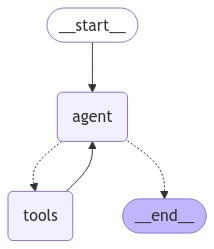

In [12]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [4]:
for chunk in app.stream(
    {"messages": [("human", "what's the weather in sf? and what's the coolest cities?")]}, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

what's the weather in sf? and what's the coolest cities?


2024-12-15 09:56:29,599 - httpx - INFO - HTTP Request: POST https://api.ai-yyds.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================
Tool Calls:
  get_weather (call_79kC2lPNzDeCFaDYVjAgBoM3)
 Call ID: call_79kC2lPNzDeCFaDYVjAgBoM3
  Args:
    location: San Francisco
  get_coolest_cities (call_Zr1CAGxhogq8xVfrOQqqypl9)
 Call ID: call_Zr1CAGxhogq8xVfrOQqqypl9
  Args:
================================= Tool Message =================================
Name: get_coolest_cities

nyc, sf


2024-12-15 09:56:36,232 - httpx - INFO - HTTP Request: POST https://api.ai-yyds.com/v1/chat/completions "HTTP/1.1 200 OK"


================================== Ai Message ==================================

The weather in San Francisco is currently 60 degrees and foggy. As for the coolest cities, New York City (NYC) and San Francisco (SF) are among them.


In [5]:
for chunk in app.stream(
    {"messages": [("human", "what's the weather in sf? and what's the coolest cities?")]}, stream_mode="values"
):
    print(chunk)

{'messages': [HumanMessage(content="what's the weather in sf? and what's the coolest cities?", additional_kwargs={}, response_metadata={}, id='3c92ee54-9e1a-4dce-950f-b66e36c26e53')]}


2024-12-15 10:01:38,173 - httpx - INFO - HTTP Request: POST https://api.ai-yyds.com/v1/chat/completions "HTTP/1.1 200 OK"


{'messages': [HumanMessage(content="what's the weather in sf? and what's the coolest cities?", additional_kwargs={}, response_metadata={}, id='3c92ee54-9e1a-4dce-950f-b66e36c26e53'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_oOA2u6u1UhIQokc3d4UZ1hQz', 'function': {'arguments': '{"location": "San Francisco"}', 'name': 'get_weather'}, 'type': 'function'}, {'id': 'call_5lk5Zx39pHH8XgWkfhV5hLf4', 'function': {'arguments': '{}', 'name': 'get_coolest_cities'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 47, 'prompt_tokens': 77, 'total_tokens': 124, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_04751d0b65', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-96d92f6d-40e4-4ff0-b0cf-1574b84ab995-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'San Francisco'}, 'id': 'call_oOA2u6u1UhIQokc3d4UZ1hQz', 'type': 'tool

2024-12-15 10:01:41,415 - httpx - INFO - HTTP Request: POST https://api.ai-yyds.com/v1/chat/completions "HTTP/1.1 200 OK"


{'messages': [HumanMessage(content="what's the weather in sf? and what's the coolest cities?", additional_kwargs={}, response_metadata={}, id='3c92ee54-9e1a-4dce-950f-b66e36c26e53'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_oOA2u6u1UhIQokc3d4UZ1hQz', 'function': {'arguments': '{"location": "San Francisco"}', 'name': 'get_weather'}, 'type': 'function'}, {'id': 'call_5lk5Zx39pHH8XgWkfhV5hLf4', 'function': {'arguments': '{}', 'name': 'get_coolest_cities'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 47, 'prompt_tokens': 77, 'total_tokens': 124, 'completion_tokens_details': None, 'prompt_tokens_details': None}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_04751d0b65', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-96d92f6d-40e4-4ff0-b0cf-1574b84ab995-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'San Francisco'}, 'id': 'call_oOA2u6u1UhIQokc3d4UZ1hQz', 'type': 'tool